## Importing libraries and dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
data = pd.read_csv('consumption_temp.csv')
data['time']= pd.to_datetime(data['time'])
data['dayofweek'] = data['time'].dt.day_name()
data['weeknumber'] = data['time'].dt.isocalendar().week
data['month'] = data['time'].dt.month_name()
data['weeknumber'] = data['weeknumber'].astype("int")
data['hour'] = data['time'].dt.hour

## Creating initial visualization of the raw dataset

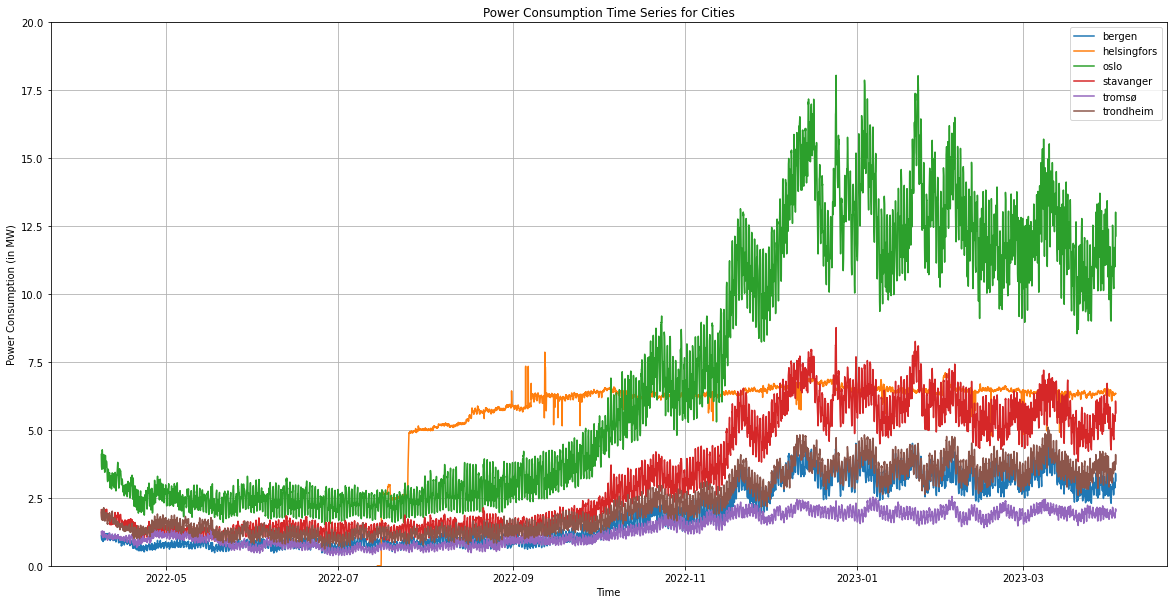

In [3]:
y_max_value = 20
y_min_value = -10

# Group the data by unique cities
city_groups = data.groupby('location')

# Create a plot showing time series of power consumption for each city with different colors
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed

for city, city_data in city_groups:
    plt.plot(city_data['time'], city_data['consumption'], label=city)

plt.title('Power Consumption Time Series for Cities')
plt.xlabel('Time')
plt.ylabel('Power Consumption (in MW)')
plt.ylim(0, y_max_value)  # Set the y-axis limits
plt.legend()
plt.grid(True)

plt.show()

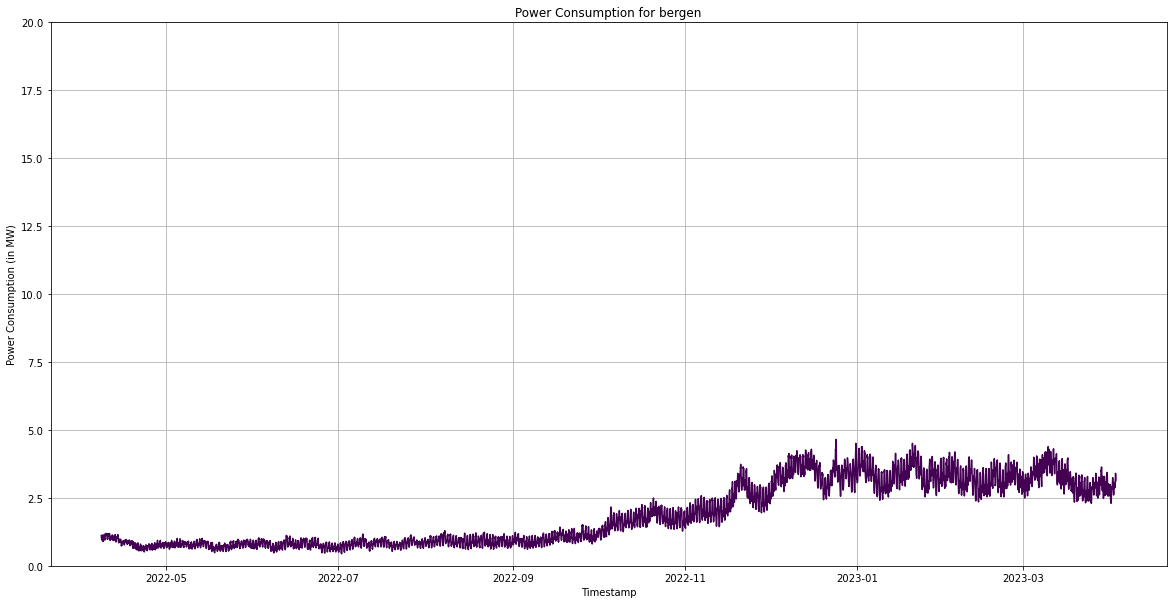

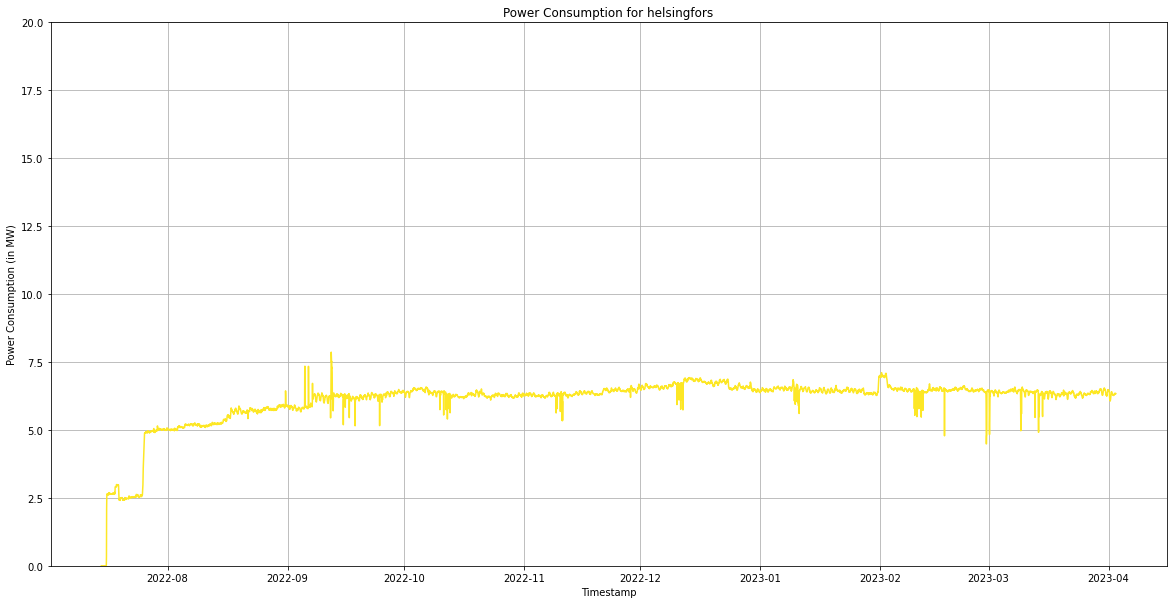

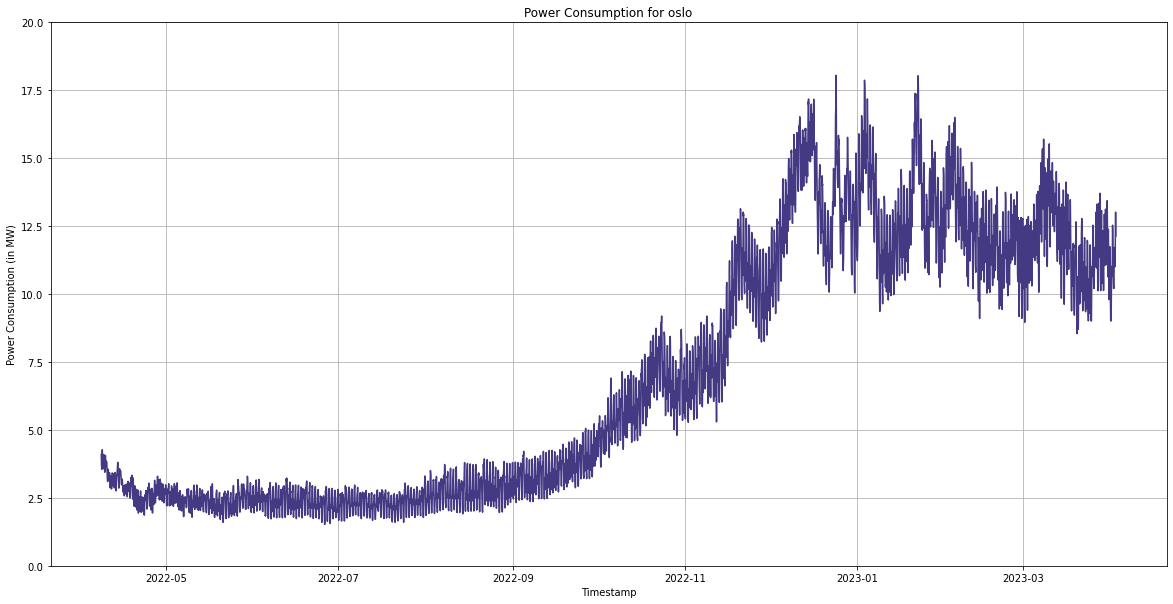

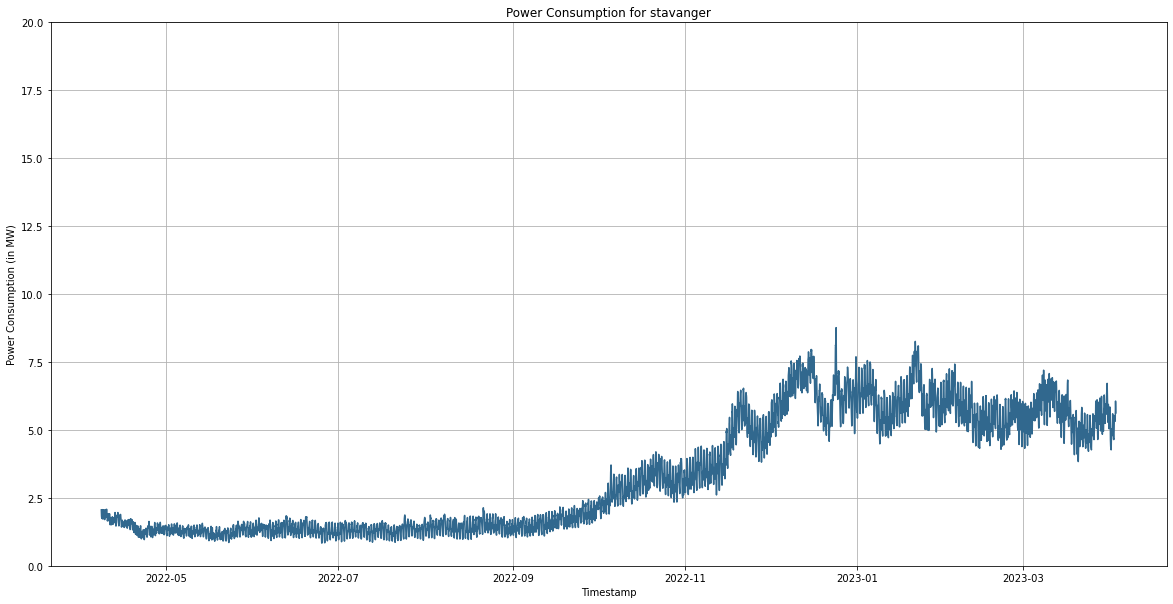

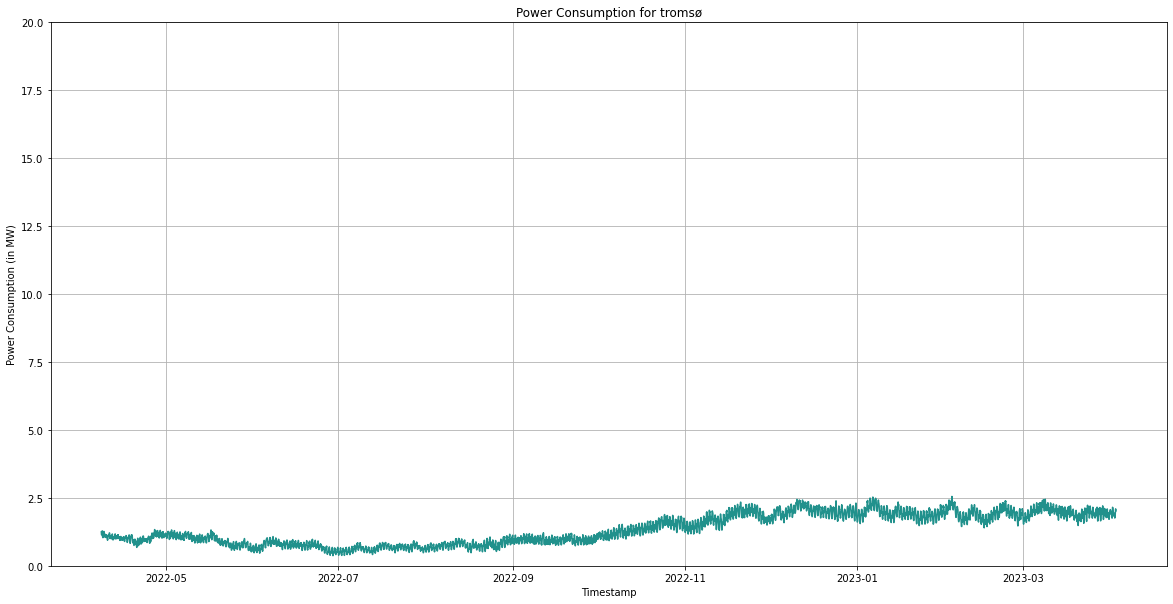

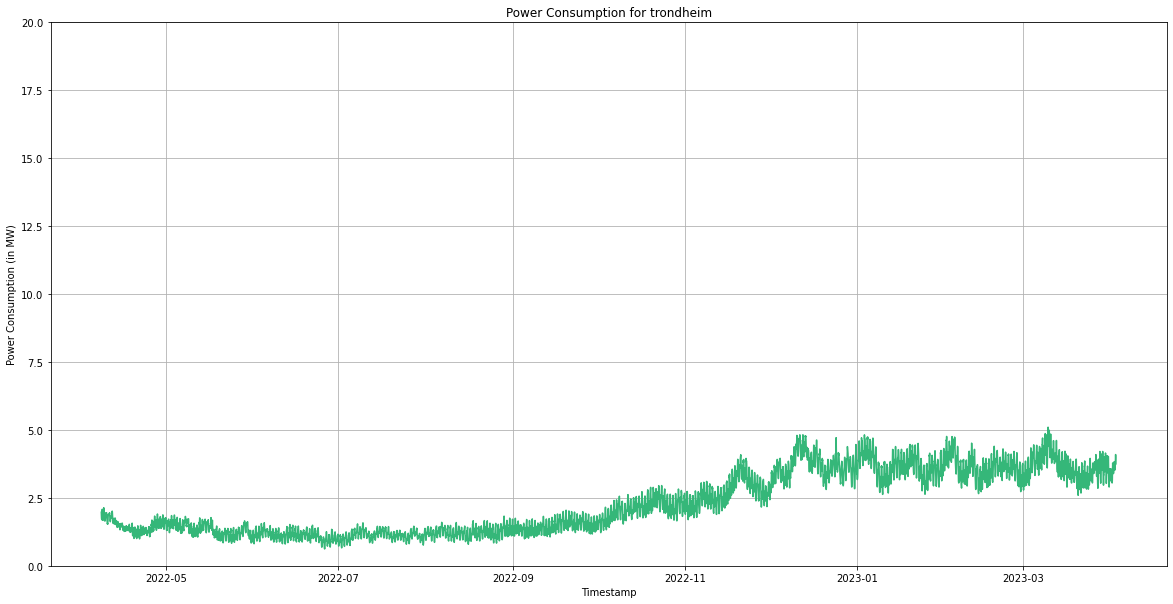

In [4]:
for city, city_data in city_groups:
    plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
    
    # Generate a unique color for each city
    color = plt.cm.viridis(city_groups.groups[city][0] / len(city_groups))

    plt.plot(city_data['time'], city_data['consumption'], color=color)
    plt.title(f'Power Consumption for {city}')
    plt.xlabel('Timestamp')
    plt.ylabel('Power Consumption (in MW)')
    plt.ylim(0, y_max_value)  # Set the y-axis limits
    plt.grid(True)
    plt.show()

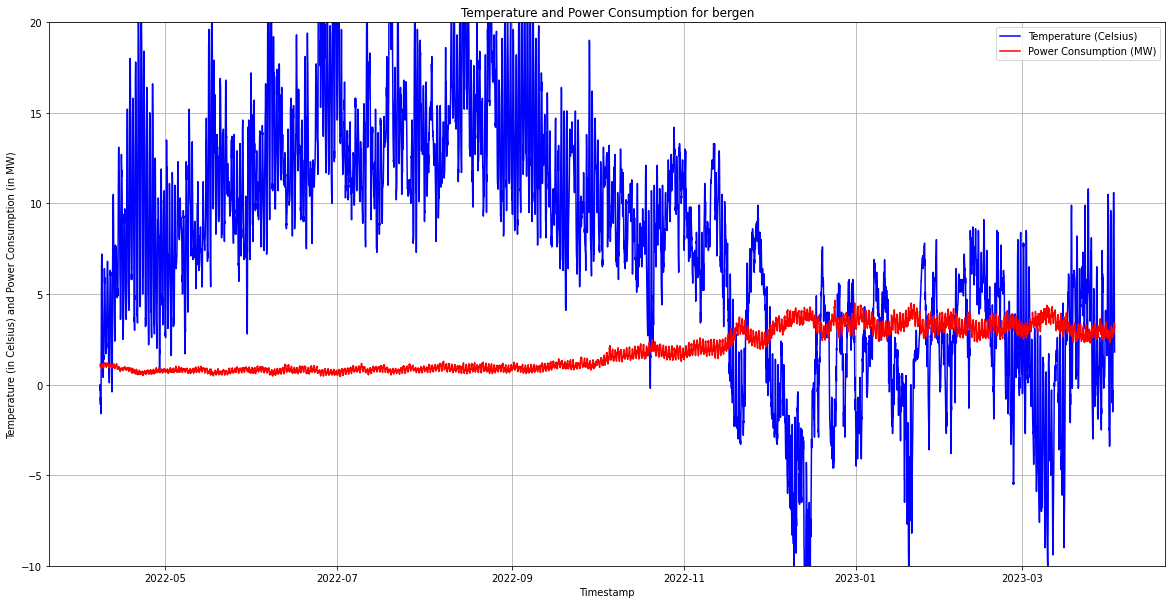

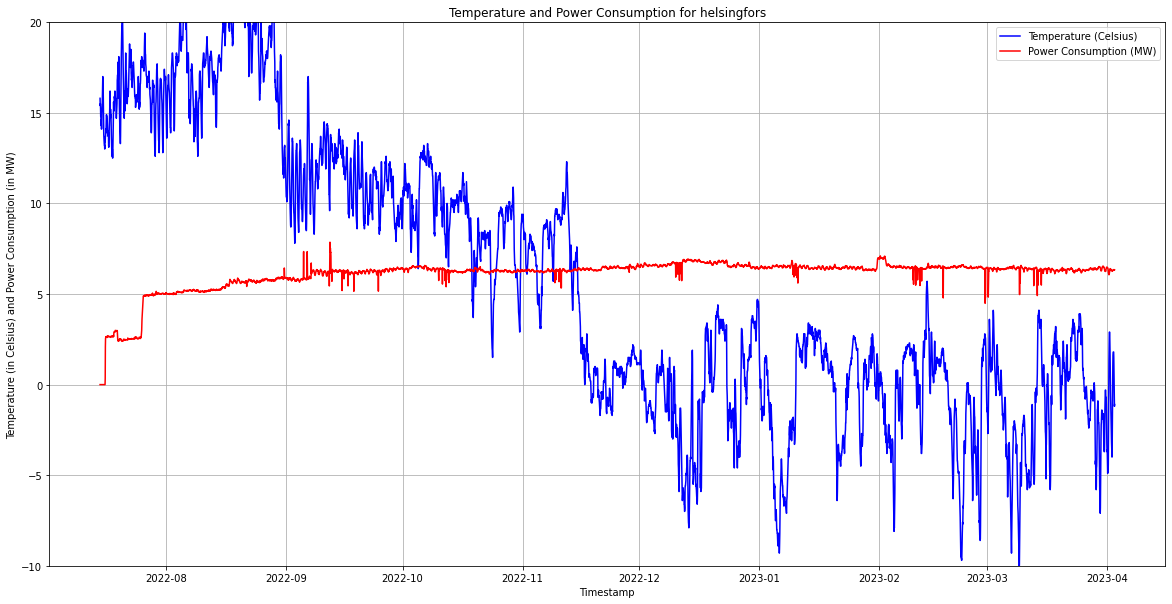

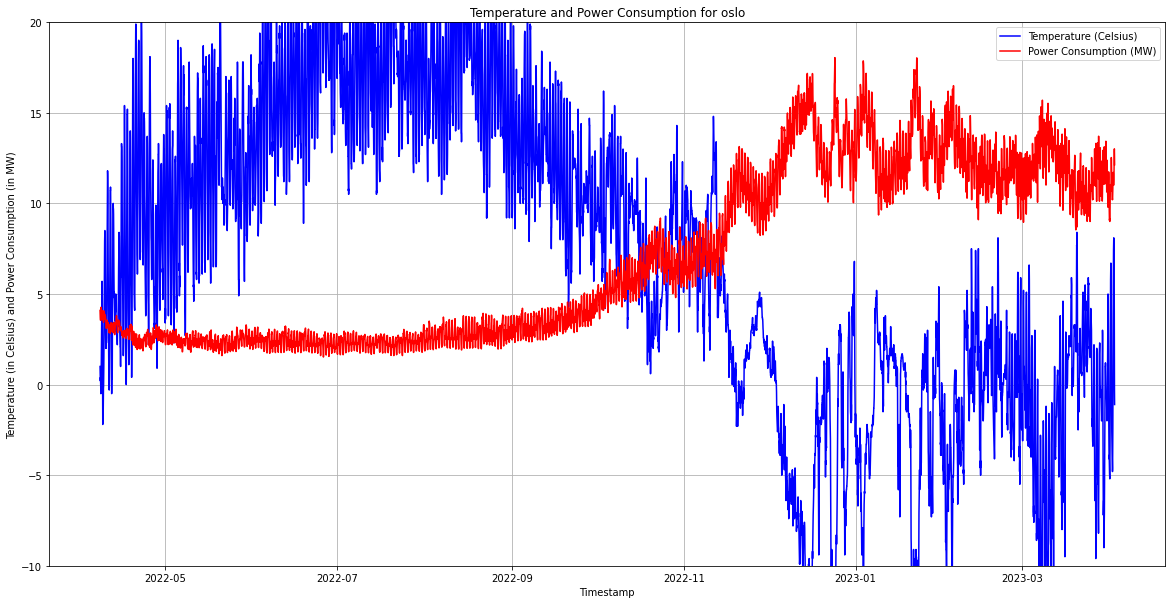

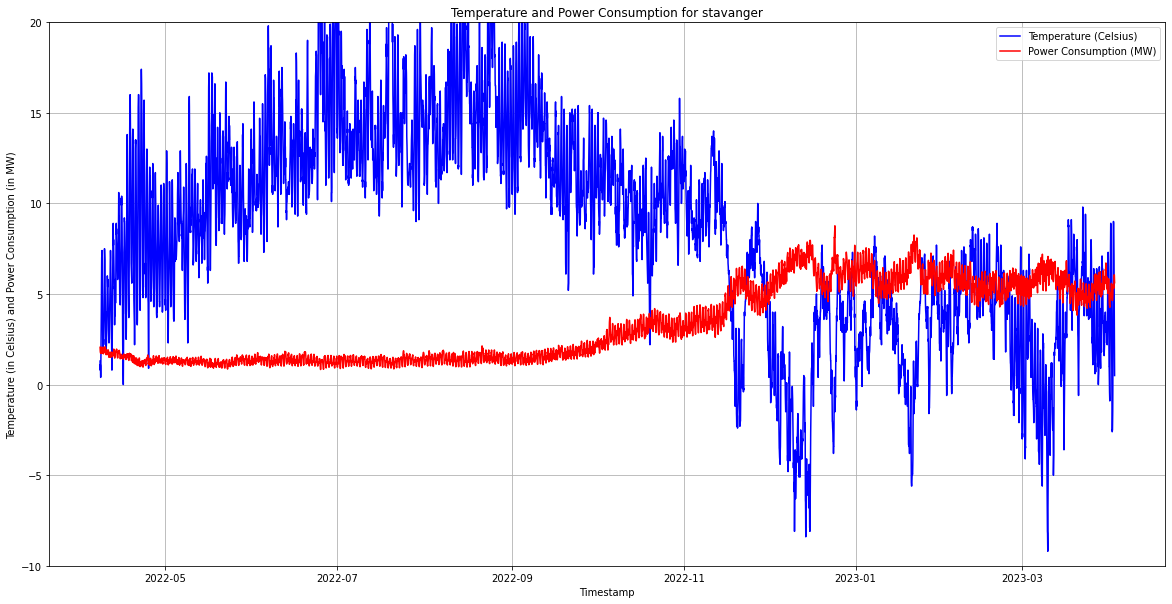

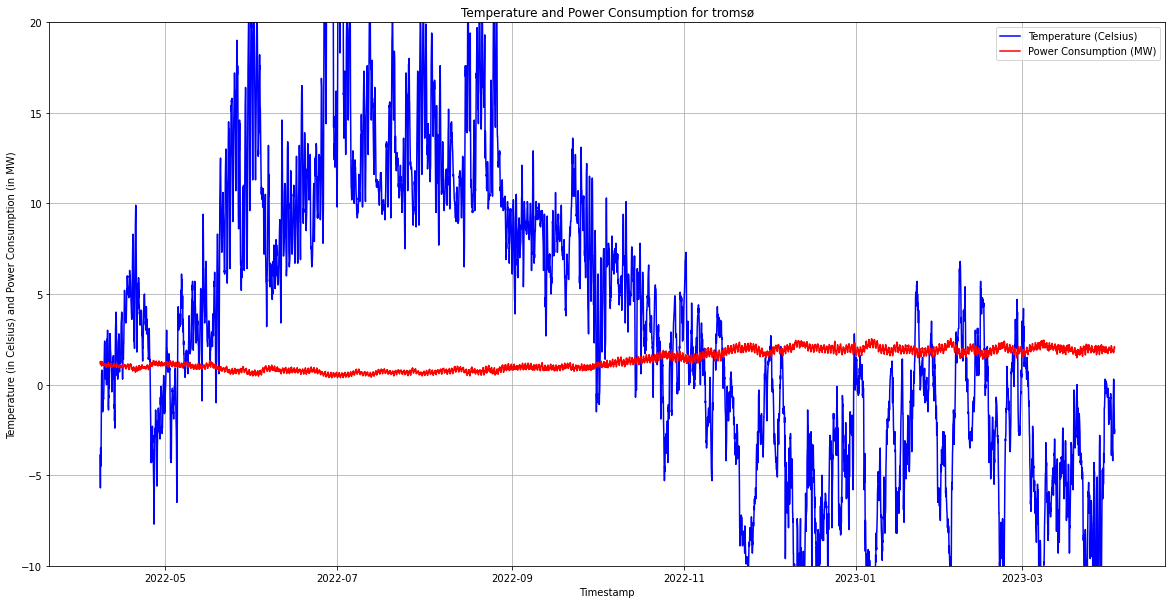

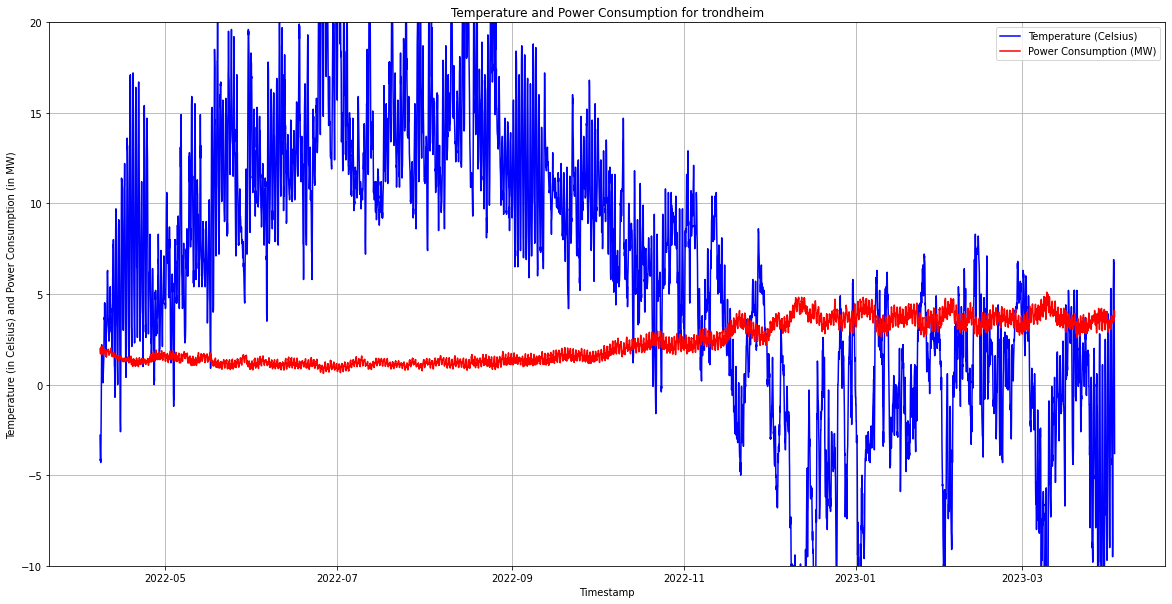

In [5]:
for city, city_data in city_groups:
    plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
    
    # Generate unique colors for temperature and power consumption
    temp_color = 'blue'
    consumption_color = 'red'

    # Plot temperature in blue
    plt.plot(city_data['time'], city_data['temperature'], color=temp_color, label='Temperature (Celsius)')
    
    # Plot power consumption in yellow
    plt.plot(city_data['time'], city_data['consumption'], color=consumption_color, label='Power Consumption (MW)')

    plt.title(f'Temperature and Power Consumption for {city}')
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature (in Celsius) and Power Consumption (in MW)')
    plt.ylim(y_min_value, y_max_value)  # Set the y-axis limits
    plt.legend()
    plt.grid(True)
    plt.show()

## Creating lag features

In [9]:
data.set_index('time', drop=True, inplace=True)
df = data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49494 entries, 2022-04-07 21:00:00 to 2023-04-02 21:00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   location     49494 non-null  object 
 1   consumption  49494 non-null  float64
 2   temperature  49494 non-null  float64
 3   dayofweek    49494 non-null  object 
 4   weeknumber   49494 non-null  int64  
 5   month        49494 non-null  object 
 6   hour         49494 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 3.0+ MB


In [10]:
# Function to add lag features
def add_lag_features(df, target_column, lag_values):
    for lag in lag_values:
        df[f'{target_column}_lag_{int((lag/168))}w'] = df.groupby('location')[target_column].shift(lag)

# Lag values for 1, 2, 3, and 4 hours
lag_values = [168, 336, 504, 672]

# Add lag features for the 'target' column
add_lag_features(df, 'consumption', lag_values)

## Exploring difference between consumption and 1 week lag consumption

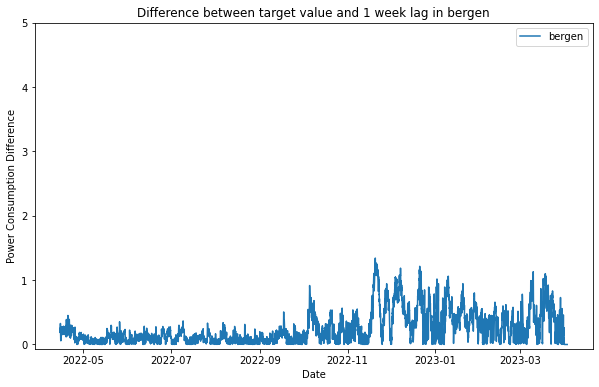

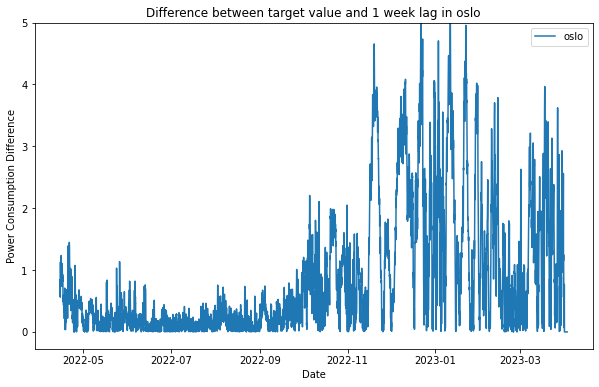

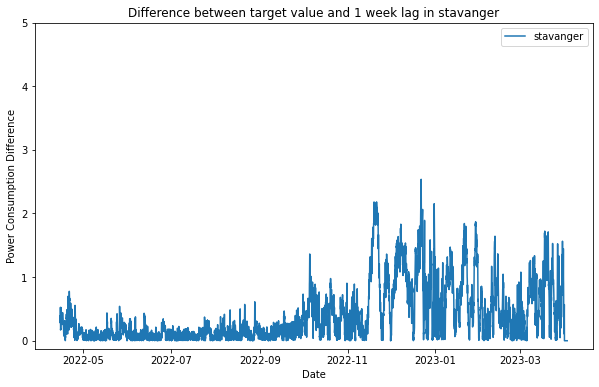

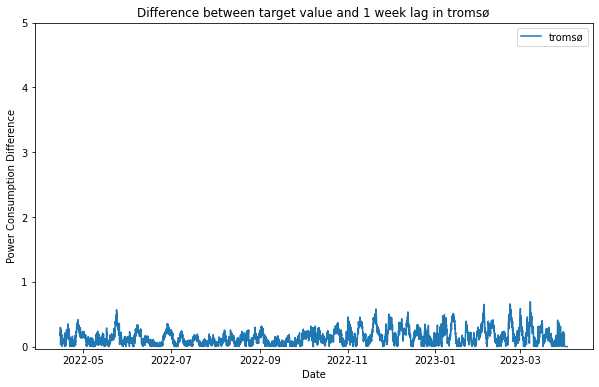

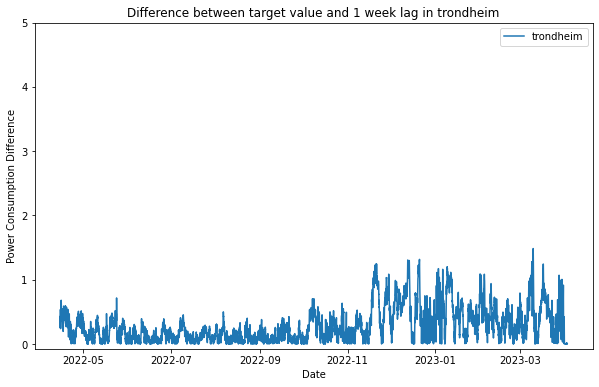

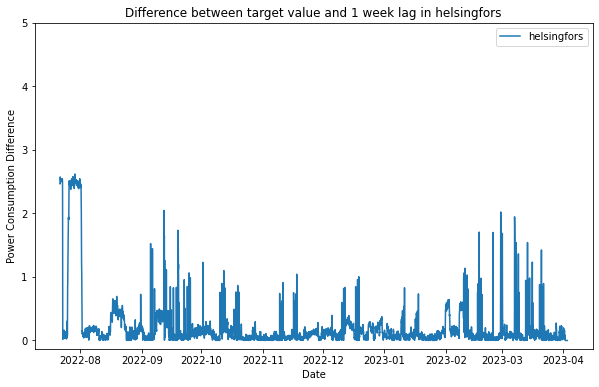

In [11]:
# Get unique cities in the dataframe
cities = df['location'].unique()

# Plotting the difference for each city
for city in cities:
    plt.figure(figsize=(10, 6))
    
    # Filter data for the current city
    city_data = df[df['location'] == city]
    
    # Calculate the difference between real and predicted consumption
    difference = abs(city_data['consumption'] - city_data['consumption_lag_1w'])
    
    plt.plot(city_data.index, difference, label=f"{city}")
    plt.title(f"Difference between target value and 1 week lag in {city}")
    plt.xlabel("Date")
    plt.ylabel("Power Consumption Difference")
    plt.ylim(top=5)
    plt.legend()
    plt.show()

## Exploring weekly seasonality for each city

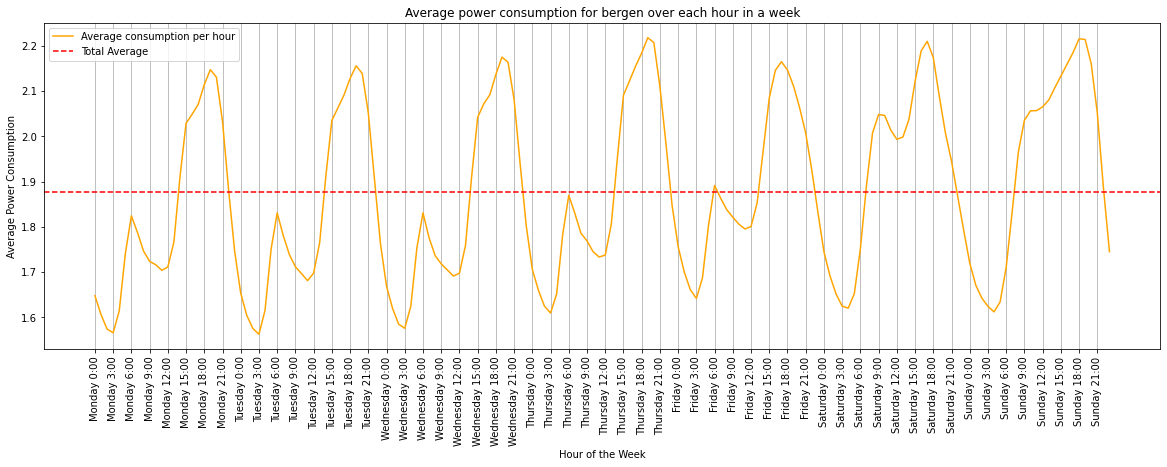

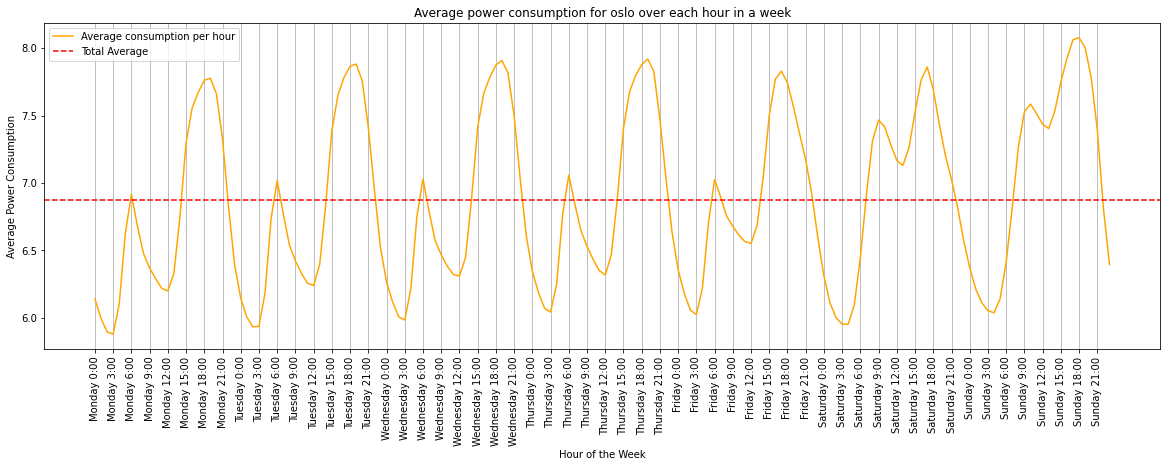

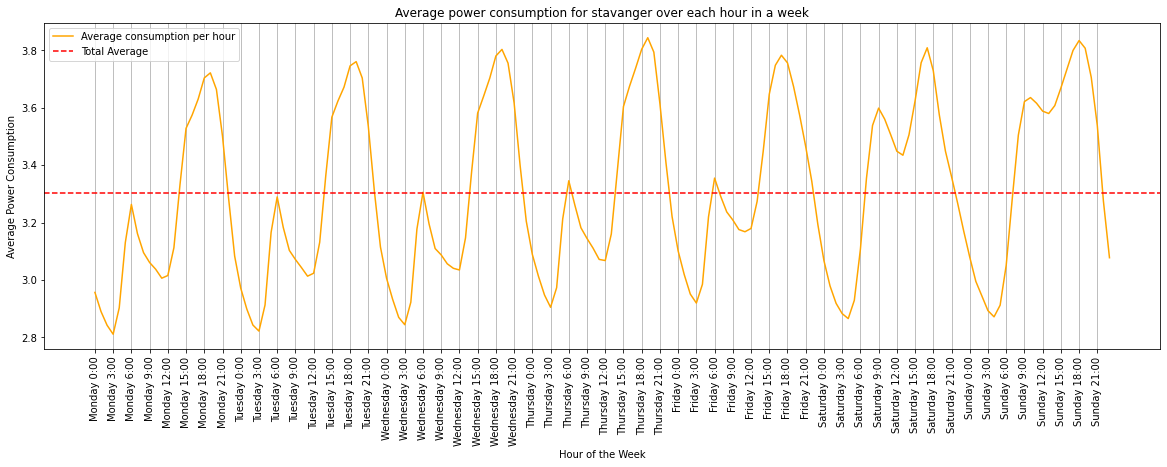

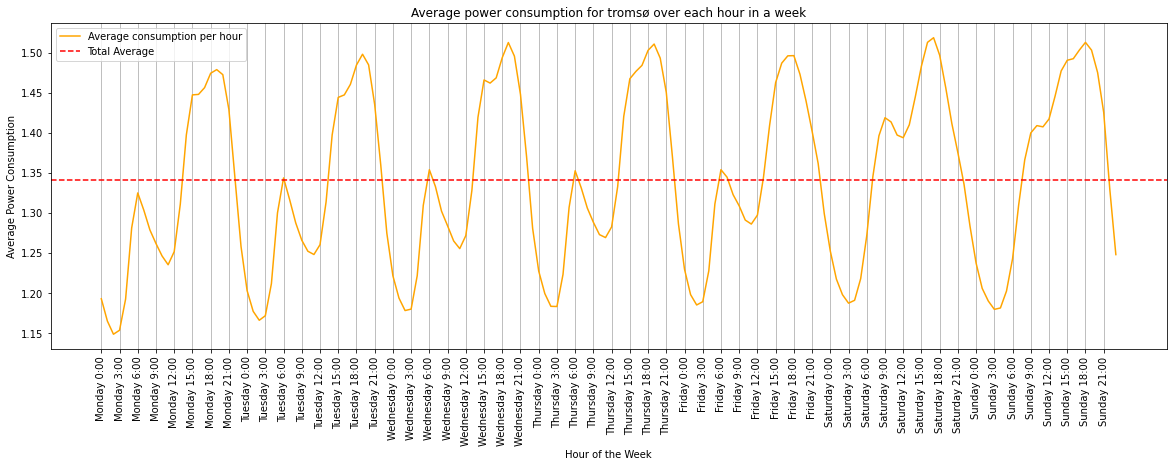

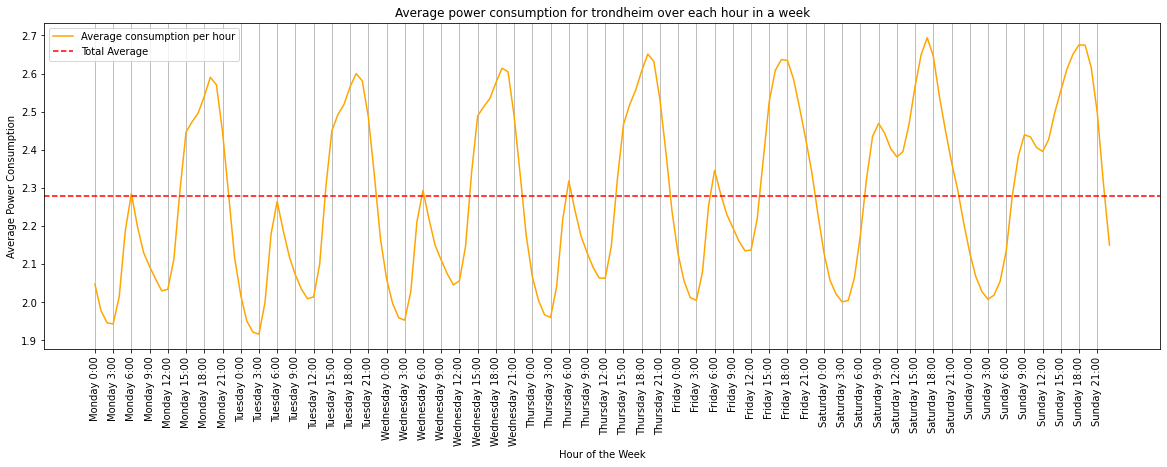

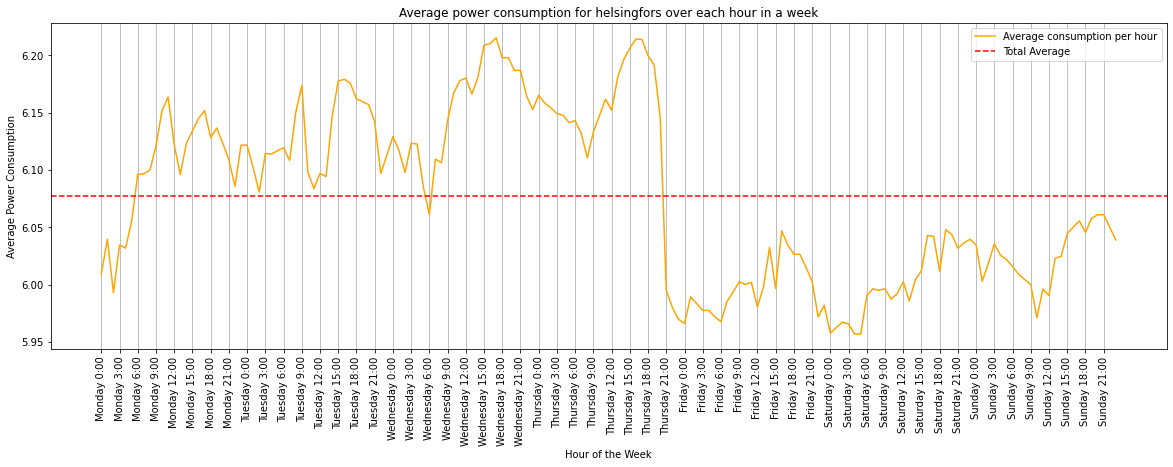

In [22]:
# Get unique cities in the dataframe
cities = df['location'].unique()

# Plotting the average power consumption for each city over a week
for city in cities:
    plt.figure(figsize=(20, 6))
    
    # Filter data for the current city
    city_data = df[df['location'] == city]
    
    # Group by weekday and hour and calculate the average power consumption
    average_power_per_hour = city_data.groupby([city_data['dayofweek'], city_data['hour']])['consumption'].mean()
    
    # Reorder weekdays for proper plotting
    weekdays_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    average_power_per_hour = average_power_per_hour.unstack().reindex(weekdays_order).stack()
    total_average = city_data['consumption'].mean()
    
    # Plotting
    average_power_per_hour.plot(kind='line', linestyle='-', color='orange', label='Average consumption per hour')
    plt.axhline(y=total_average, color='red', linestyle='--', label='Total Average')
    plt.title(f'Average power consumption for {city} over each hour in a week')
    plt.xlabel('Hour of the Week')
    plt.ylabel('Average Power Consumption')
    plt.xticks(range(0, 7 * 24, 3), ['{} {}:00'.format(day, hour) for day in weekdays_order for hour in range(0, 24, 3)], rotation=90)
    plt.grid(visible=True,axis='x')
    plt.legend()    
    plt.show()